In [1]:
# Include libraries
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
from warnings import simplefilter
import matplotlib.pyplot as plt
# Stop warnings from printing
simplefilter('ignore')
from copy import deepcopy
import numpy as np

import cpuinfo
import sys
import math
import time
import os

# Load pytorch
import torch
import torchvision

In [2]:
from Scripts.pytorchHelpers import dataLoading, visual, devices
from Scripts import VGG16FCN

In [3]:
device = devices.getDevice()

Found 2 GPUs:
GPU 0: GeForce GTX 1070
GPU 1: GeForce GTX 1070


In [4]:
# Instance a FCN base on VGG16
FCN8 = VGG16FCN.FCN8(2)
# Make a transformer for the data loader
transformer = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((375, 1241)),
    torchvision.transforms.ToTensor()
    ])

# Build a collection of batch iomage loaders
loaders = dataLoading.buildDataloaders(3, 0.2, '\\Data\\data_road\\', 
                                       'training\\raw\\', 'training\\gt\\',
                                       'testing\\', transformerTrain = transformer,
                                      transformerTest = transformer)

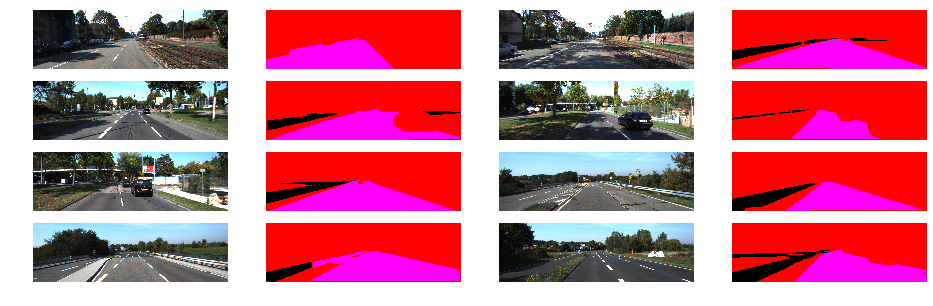

In [5]:
# Get current working directory
path =  os.getcwd() + "\Data\data_road"
pathRaw = path + "\\training\\raw\\image_2"
pathGroundTruth = path + "\\training\\gt\\gt_image_2"
groundTruthFiles = os.listdir(pathGroundTruth)
rawFiles = os.listdir(pathRaw)

# Print examples of the images
Figure = plt.figure(figsize=(16, 5))
for i in range(16):
    if (i % 2 != 0):
        tmpFilePath = pathGroundTruth + "\\" + groundTruthFiles[i]
    else:
        tmpFilePath = pathRaw + "\\" + rawFiles[i]
    
    tmpImage = plt.imread(tmpFilePath)
    Figure.add_subplot(4, 4, i+1).axis('off')
    plt.imshow(tmpImage)

0 torch.Size([3, 3, 375, 1241])
0 torch.Size([3, 3, 375, 1241])


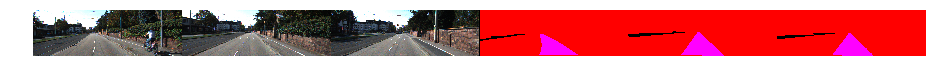

In [6]:
# Confirming that sequential loaders are working
for batch, gtrawBatched in enumerate(zip(loaders['train'], loaders['trainGT'])):
    print(batch, gtrawBatched[0][0].size())
    print(batch, gtrawBatched[1][0].size())
    # generate 2nd batch and display it
    if batch == 0:
        plt.figure(figsize=(16, 14))
        tensors = torch.cat((gtrawBatched[0][0], gtrawBatched[1][0]))
        img = visual.tensorToNumpy(tensors)
        plt.axis('off')
        plt.imshow(img)
        plt.savefig('Figures\\BatchExample.png')
        break 

In [7]:
# Optimser, Scheduler and Loss Function
optimiser = torch.optim.SGD(FCN8.parameters(), lr = 0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, 20)
lossFN = torch.nn.MultiLabelSoftMarginLoss()

In [8]:
def trainFCN(network, lossFn, optimiser, scheduler, NumberOfEpochs, batchLoader):
    start = time.time()
    # Reset best model found and the highest validation accuracy seen
    BestModel = deepcopy(network.state_dict())
    HighestAcc = 0.0
    # Push the network to the active device
    if torch.cuda.device_count() > 1:
        # Use Multiple GPUs if available
        network = torch.nn.DataParallel(network)
    
    network.to(device)
    
    # Make some lists to track loss and accuracy
    trainingLoss = list()
    validationLoss = list()
    trainingAcc = list()
    validationAcc = list()
    
    # Preform training and validation NumberOfEpochs times
    for epoch in range(1, NumberOfEpochs + 1):
        print('Epoch: {}/{}'.format(epoch, NumberOfEpochs))

        # Each epoch has a training and validation phase
        for stage in ['train', 'trainVali', 'vali']:
            if stage == 'train':               
                scheduler.step()
                # The network will be updated
                network.train()  
            else:
                # The network will not be updated
                network.eval()   
            
            # Reset evaluation metrics
            loss = 0.0
            correct = 0

            # Iterate over data.
            for gtrawBatched in tqdm(zip(batchLoader[stage],
                                         batchLoader[stage+'GT'])):
                # Sends the current batch of images/GTs to the 
                # active processor
                images = gtrawBatched[0][0].to(device)
                labels = gtrawBatched[1][0].to(device)

                # Reset the optimisers gradient to zero
                optimiser.zero_grad()

                # forward
                # track history while trainning
                with torch.set_grad_enabled(stage == 'train'):
                    # Use the model on the batch and extract prediction
                    # by taking the maximum across the class channels                  
                    output = network(images)
                    #predictions = torch.max(output, dim = 1)
                    print(output.size())
                    #print(predictions[0].size())
                    visual.plotOutputTensor(output)
                    
                    predictions = torch.argmax(output, dim=1)
                    print(predictions.size())
                    print(predictions)
                    visual.plotPredictionTensor(predictions)
                    labels.resize_as_(predictions.float())
                    lossValue = lossFn(predictions.float(), labels)

                    # If we are training, back propagate the loss
                    #  and advance the optimiser
                    if stage == 'train':
                        # Propagrate the loss back through the network
                        lossValue.backward()
                        # Step the optimiser forward using the current
                        # gradient
                        optimiser.step()

                # Add to evaluation metrics
                loss += lossValue.item() * images.size(0)
                correct += torch.sum(predictions == labels.data)
                
                
            # Calulcate the total loss and accuracy for the batch
            epochLoss = loss / len(batchLoader[stage].dataset)
            epochAcc = correct.double() / len(batchLoader[stage].dataset)
            
            if stage == 'trainVali':
                print('Training')
                trainingAcc.append(epochAcc)
                trainingLoss.append(epochLoss)
                print('Loss: {:.4f} Accuracy: {:.4f}'.format(epochLoss, epochAcc))
                
            if stage == 'vali':
                print('Validation')
                validationAcc.append(epochAcc)
                validationLoss.append(epochLoss)
                print('Loss: {:.4f} Accuracy: {:.4f}'.format(epochLoss, epochAcc))
            
            
            # Deepcopy the network if its better than the current best
            if stage == 'vali' and epochAcc >= HighestAcc:
                HighestAcc = epochAcc
                bestModel = deepcopy(network.state_dict())
                
        print('='*30)
        
    end = time.time()
    runtime = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.2f}s'.format(runtime//(60*60), (runtime%(60*60))//60, runtime%60))
    print('Best val Acc: {:.4f}%'.format(HighestAcc*100))

    # Save best model and Final model
    torch.save(network.state_dict(), os.getcwd() + '\\Models\\FCN-Final.pwf')
    network.load_state_dict(bestModel)
    torch.save(network.state_dict(), os.getcwd() + '\\Models\\FCN-Final.pwf')
    
    # Clear the GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return trainingLoss, trainingAcc, validationLoss, validationAcc

Epoch: 1/2


torch.Size([3, 2, 568, 1432])
torch.Size([3, 568, 1432])
tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

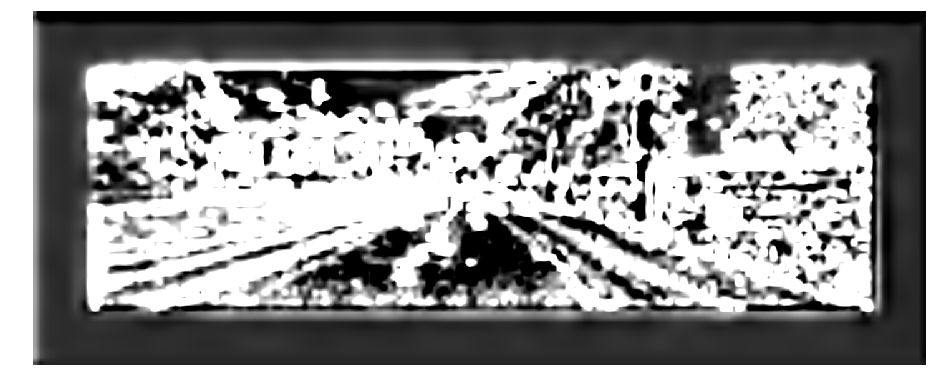

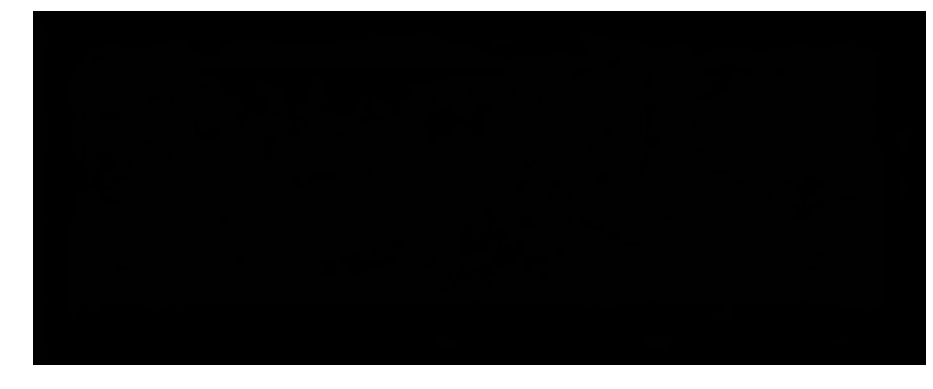

In [9]:
trainFCN(FCN8, lossFN, optimiser, scheduler, 2, loaders)

In [11]:
from Scripts.convOutputSize import convolutionOutputSize
from Scripts.convOutputSize import maxpoolOutputSize

In [21]:
print(convolutionOutputSize([375, 1242], [3, 3], [100, 100]))
print(convolutionOutputSize([573.0, 1440.0], [3, 3], [1, 1]))
print(maxpoolOutputSize([573.0, 1440.0], [2, 2], 1))
# When input dimensions are odd roudning down in the tesnor size occurs
print(maxpoolOutputSize([286.5, 720.0], [2, 2], 1))
print(maxpoolOutputSize([143.25, 360.0], [2, 2], 1))
print(maxpoolOutputSize([71.625, 180.0], [2, 2], 1))
print(maxpoolOutputSize([35.8125, 90.0], [2, 2], 1))
# Gives error in forward propagation

[573.0, 1440.0]
[573.0, 1440.0]
[286.5, 720.0]
[143.25, 360.0]
[71.625, 180.0]
[35.8125, 90.0]
[17.90625, 45.0]


In [18]:
print(convolutionOutputSize([375, 1242], [1, 1]))

[375.0, 1242.0]
